<a href="https://www.kaggle.com/code/idjiotsandwiches/resnet-transfer-learning?scriptVersionId=214038527" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /kaggle/input/fer2013


In [2]:
import os
import cv2 as cv
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pathlib
import seaborn as sns

E0000 00:00:1734702751.679276      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1220 13:52:31.687533786      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1220 13:52:31.687548871      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1220 13:52:31.687552268      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1220 13:52:31.687554816      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1220 13:52:31.687557407      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1734702763.424349      13 service.cc:145] XLA service 0x5ad264375c00 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734702763.424421      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1734702763.424426      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1734702763.424429      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1734702763.424444      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1734702763.424447      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1734702763.424450      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1734702763.424453      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1734702763.424456      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [29]:
TRAIN_PATH = pathlib.Path('/kaggle/input/d/idjiotsandwiches/fer2013/FER2013-down_sampling_augmented')
TEST_PATH = pathlib.Path('/kaggle/input/fer2013/test')
LABEL_NAMES = ["angry", "fear", "happy", "neutral", "sad", "surprise"]
NUM_CLASSES = len(LABEL_NAMES)
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
IMG_SIZE = (48,48)
AUTOTUNE = tf.data.AUTOTUNE
IMG_SHAPE = IMG_SIZE + (3,)
VALIDATION_SPLIT = 0.3
SEED = 42
SHUFFLE = True

LABEL_INDICES = [i for i in range(0, NUM_CLASSES)]

model_params = {
    'train_path': TRAIN_PATH,
    'test_path': TEST_PATH,
    'label_names': LABEL_NAMES,
    'num_classes': NUM_CLASSES,
    'batch_size': BATCH_SIZE,
    'img_size': IMG_SIZE,
    'img_shape': IMG_SHAPE,
    'validation_split': VALIDATION_SPLIT,
    'seed': SEED,
    'shuffle': SHUFFLE
}

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_names=LABEL_NAMES
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_names=LABEL_NAMES
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=IMG_SIZE,
    class_names=LABEL_NAMES
)

train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 72000 files belonging to 6 classes.
Using 50400 files for training.
Found 72000 files belonging to 6 classes.
Using 21600 files for validation.
Found 7067 files belonging to 6 classes.


In [6]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              verbose=1,
                              min_delta=0.0001)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(LABEL_INDICES), y=LABEL_INDICES)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
preprocess_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomTranslation(0,0.1)
])

def augment(image, label):
    image = preprocess_layer(image)
    return image, label

train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE).shuffle(BATCH_SIZE).prefetch(AUTOTUNE)

In [7]:
with tpu_strategy.scope():
    model = tf.keras.Sequential([

        # input layer
        tf.keras.layers.Input(shape=IMG_SHAPE),
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 1st hidden dense layer
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 2nd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 3rd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # Flatten layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        # output layer
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    model.summary()
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    history = model.fit(train_ds, epochs=100,validation_data=val_ds, callbacks=[earlystop, reduce_lr])

I0000 00:00:1734702790.849497      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 111, 111, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 111, 111, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 55, 55, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 55, 55, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 27, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27, 27, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 13, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,468,486 (97.15 MB)

 Trainable params: 25,464,518 (97.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

Epoch 1/100


2024-12-20 13:53:43.245084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1734702842.977463     817 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(667946b44982c5da:0:0), session_name()


  1/394 ━━━━━━━━━━━━━━━━━━━━ 4:29:46 41s/step - accuracy: 0.4375 - loss: 9.6890

I0000 00:00:1734702861.662180     817 tpu_compile_op_common.cc:245] Compilation of 667946b44982c5da:0:0 with session name  took 18.684666254s and succeeded
I0000 00:00:1734702861.703035     817 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(667946b44982c5da:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_435336011374323068", property.function_library_fingerprint = 5157147007495806863, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,224,224,3,;16,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734702861.703094     817 tpu_compilation_cache_interface.cc:541] After adding entry for key 66

212/394 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.2301 - loss: 9.2853

I0000 00:00:1734702880.236142     790 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8699101ab263808e:0:0), session_name()


213/394 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - accuracy: 0.2302 - loss: 9.2834

I0000 00:00:1734702899.398121     790 tpu_compile_op_common.cc:245] Compilation of 8699101ab263808e:0:0 with session name  took 19.161929112s and succeeded
I0000 00:00:1734702899.446837     790 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8699101ab263808e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_435336011374323068", property.function_library_fingerprint = 5157147007495806863, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "12,224,224,3,;12,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734702899.446880     790 tpu_compilation_cache_interface.cc:541] After adding entry for key 86

394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2448 - loss: 8.9612

2024-12-20 13:55:18.129642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1734702918.680195     771 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f9e367798f2a2a3b:0:0), session_name()
I0000 00:00:1734702924.885328     771 tpu_compile_op_common.cc:245] Compilation of f9e367798f2a2a3b:0:0 with session name  took 6.205076277s and succeeded
I0000 00:00:1734702924.890264     771 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f9e367798f2a2a3b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1856216290304288544", property.function_library_fingerprint = 11334765645864201037, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t

394/394 ━━━━━━━━━━━━━━━━━━━━ 117s 193ms/step - accuracy: 0.2449 - loss: 8.9595 - val_accuracy: 0.2193 - val_loss: 8.2899 - learning_rate: 1.0000e-04
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 65s 116ms/step - accuracy: 0.3361 - loss: 6.4362 - val_accuracy: 0.3478 - val_loss: 5.2328 - learning_rate: 1.0000e-04
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 66s 118ms/step - accuracy: 0.3971 - loss: 4.4797 - val_accuracy: 0.3389 - val_loss: 4.2371 - learning_rate: 1.0000e-04
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 66s 117ms/step - accuracy: 0.4452 - loss: 3.2312 - val_accuracy: 0.3619 - val_loss: 7.4505 - learning_rate: 1.0000e-04
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 66s 117ms/step - accuracy: 0.4736 - loss: 2.4582 - val_accuracy: 0.4452 - val_loss: 2.2043 - learning_rate: 1.0000e-04
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 66s 117ms/step - accuracy: 0.5105 - loss: 1.9858 - val_accuracy: 0.5548 - val_loss: 1.6597 - learning_rate: 1.0000e-04
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 65s 116ms/

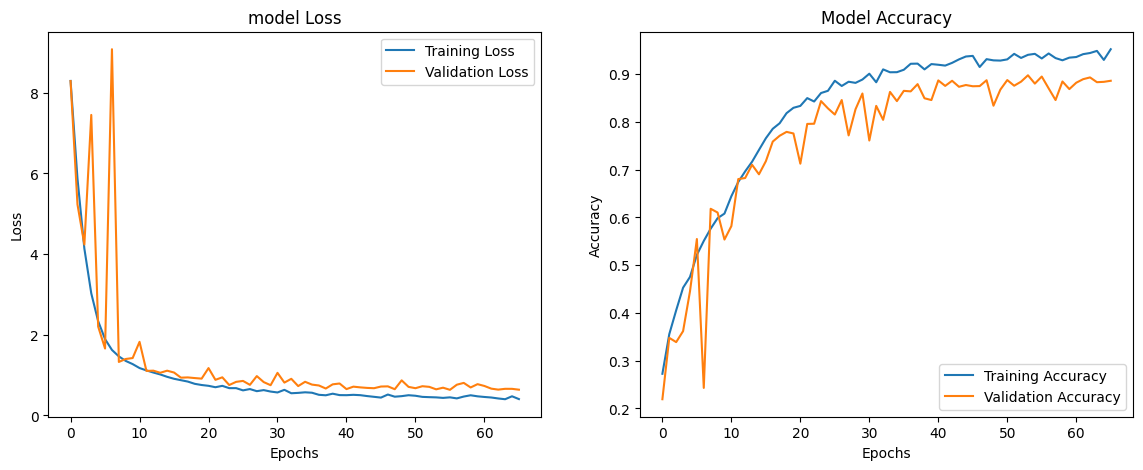

In [8]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc=0)
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend(loc=0)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()  

In [9]:
images_ = []
labels_ = []

for images, labels in test_ds:
    for img in images:
        images_.append(img.numpy())
    for label in labels:
        labels_.append(label.numpy())

images_np = np.array(images_)

pred = model.predict(images_np[:7000])

pred_res = []
for p in pred:
    pred_res.append(np.argmax(p))

print(accuracy_score(labels_[:7000], pred_res))

2024-12-20 15:07:25.352243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1734707245.411927     795 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(565a1d9d1221e528:0:0), session_name()


  3/219 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step

I0000 00:00:1734707249.516653     795 tpu_compile_op_common.cc:245] Compilation of 565a1d9d1221e528:0:0 with session name  took 4.104646419s and succeeded
I0000 00:00:1734707249.519134     795 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(565a1d9d1221e528:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_694778126820575376", property.function_library_fingerprint = 8727170196885889621, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734707249.519166     795 tpu_compilation_cache_interface.cc:541] After adding entry for key 565a1d9d1221e

218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

I0000 00:00:1734707263.650037     835 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d75894c90f7fc9f4:0:0), session_name()


219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step


I0000 00:00:1734707268.145853     835 tpu_compile_op_common.cc:245] Compilation of d75894c90f7fc9f4:0:0 with session name  took 4.495774043s and succeeded
I0000 00:00:1734707268.147498     835 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d75894c90f7fc9f4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_7670466004556150984", property.function_library_fingerprint = 12467582937034358055, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,224,224,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734707268.147525     835 tpu_compilation_cache_interface.cc:541] After adding entry for ke

0.5864285714285714


In [10]:
report = classification_report(labels_[:7000], pred_res)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.59      0.50       948
           1       0.48      0.36      0.41      1016
           2       0.80      0.77      0.78      1756
           3       0.53      0.55      0.54      1221
           4       0.47      0.41      0.44      1235
           5       0.71      0.80      0.75       824

    accuracy                           0.59      7000
   macro avg       0.57      0.58      0.57      7000
weighted avg       0.59      0.59      0.58      7000



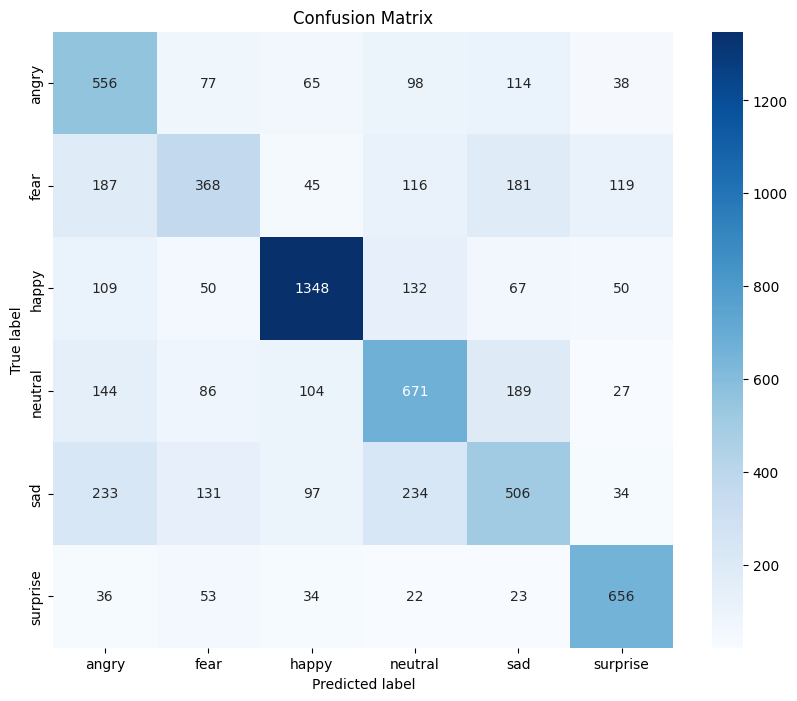

In [27]:
true_classes = LABEL_NAMES
cm = confusion_matrix(labels_[:7000], pred_res)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=true_classes, yticklabels=true_classes)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')
plt.show()

In [13]:
metrics = {
    'accuracy': accuracy_score(labels_[:7000], pred_res),
    'precision': precision_score(labels_[:7000], pred_res, average='macro'),
    'recall': recall_score(labels_[:7000], pred_res, average='macro'),
    'f1': f1_score(labels_[:7000], pred_res, average='macro'),
    'auc_score': roc_auc_score(labels_[:7000], pred, multi_class='ovr', average='macro')
}

print(f"Accuracy: {metrics['accuracy']}\nPrecision: {metrics['precision']}\nRecall: {metrics['recall']}\nF1 Score: {metrics['f1']}\nAUC Score: {metrics['auc_score']}")

Accuracy: 0.5864285714285714
Precision: 0.5703946225883189
Recall: 0.5786231711401918
F1 Score: 0.5705374457639111
AUC Score: 0.8609743786858758


In [21]:
!pip install dagshub --quiet
!pip install mlflow --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import mlflow
import dagshub
dagshub.init(repo_owner='IdjiotSandwiches', repo_name='face-emotion-recognition', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=869d5964-4058-4a51-a365-c3129759627d&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=c8be84556e99419cf28980967e1ad85678287352bbef3efe12f6b4c5c466a8bd




Accessing as IdjiotSandwiches

Initialized MLflow to track repo "IdjiotSandwiches/face-emotion-recognition"

Repository IdjiotSandwiches/face-emotion-recognition initialized!

In [24]:
for images, labels in test_ds.take(1):
    input_example = images[0].numpy()
    break 

In [25]:
model = tf.keras.models.clone_model(model)
model.save('CNN-FER.h5')

In [30]:
mlflow.set_experiment("CNN-FER")
mlflow.set_tracking_uri("https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow")

with mlflow.start_run(run_name=f'CNN-FER'):
    mlflow.log_artifact('confusion_matrix.png')
    mlflow.log_params(model_params)
    mlflow.tensorflow.log_model(
        model,
        artifact_path='CNN_FER'
    )

2024/12/20 15:31:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/12/20 15:31:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run CNN-FER at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/24/runs/8eb0dceef63d4982b9101ebc08487fee
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/24


## **For not using TPU**

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
augment = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomFlip(),
])
preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)
global_average = tf.keras.layers.GlobalAveragePooling2D()
# dropout_layer = tf.keras.layers.Dropout(0.2)
add_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
dense_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))

In [ ]:
base_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(LABEL_INDICES), y=LABEL_INDICES)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
base_model.trainable = False

x = augment(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average(x)
# x = dropout_layer(x)
x = add_layer(x)
outputs = dense_layer(x)

In [ ]:
initial_epochs = 20
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    class_weight=class_weight_dict
                   )

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)